## Standardize the item response data

In [1]:
import numpy as np
import pandas as pd
from sklearn.covariance import MinCovDet
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from pca import *
from funcs import *
from clustering import *
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv('data/pretest_data.csv')
# data = pd.read_excel('data/pretest_data.xlsx')  # error loading xlsx
# data.head()

In [3]:
response_data = np.array(data.drop(columns=['학번','성적/10']))

In [4]:
data_standardized = (response_data - np.mean(response_data, axis=0)) / np.std(response_data, axis=0)

In [5]:
items_for_each_component = {'Repetition':[1],'Probability':[2,3],'Conditional_Probablity':[4,5],
                            'Random_Variable':[6,7],'Probability_Distribution':[8,9],'Statistical_Estimation':[10]}

Robust PCA

In [6]:
robust_covariance_mat = make_robust_covariance_mat(data_standardized, centered = True)

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.234840017662492 > -74.574995286371959). You may want to try with a higher value of support_fraction (current value: 0.558).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.080539312162975 > -74.868731770501967). You may want to try with a higher value of support_fraction (current value: 0.558).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.116609293104913 > -74.736800265372324). You may want to try with a higher value of support_fraction (current value: 0.558).
  RuntimeWarning)
/usr/local/lib/python3

In [7]:
eig_values, eig_vectors = make_eig_values_and_vectors(robust_covariance_mat)

In [8]:
sorted_eig_values, sorted_eig_vectors = sort_eigen_pair(eig_values, eig_vectors)

In [9]:
fit_rpca = project(data_standardized, sorted_eig_vectors)[:,0:7]

## Gaussian Mixture Model (GMM)

Total score distribution in GMM

In [10]:
# Number of components in GMM
num_components = 5

In [11]:
gmm = GaussianMixture(n_components=num_components, random_state=0)

In [12]:
gmm.fit(fit_rpca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
gmm_labels = gmm.predict(fit_rpca)

In [14]:
sorted_index = np.argsort([np.mean(np.mean(data_standardized[gmm_labels == i] ,axis=0)) for i in range(num_components)])[::-1]

In [15]:
df_gmm = pd.DataFrame(fit_rpca)
df_gmm['cluster_gmm'] = sort_categories_by_mean(gmm_labels, sorted_index)

In [16]:
gmm_cluster_index = df_gmm['cluster_gmm']

In [17]:
data['cluster_index'] = df_gmm['cluster_gmm']

In [18]:
# save ID and cluster index to a csv file
#data[['학번','cluster_index']].to_csv('results/pretest_rpca_clustering.csv', index=None)

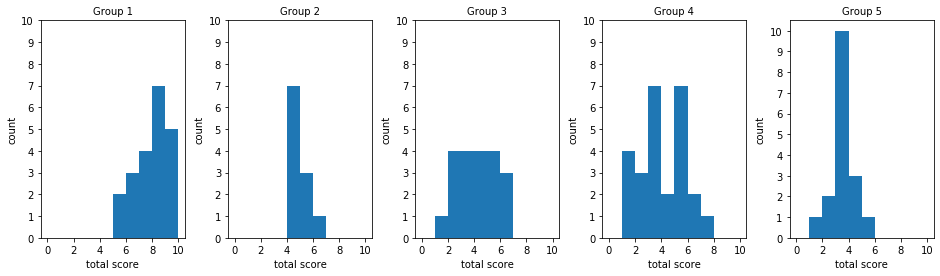

In [19]:
plt.figure(figsize=(16,4))
bins = np.linspace(0,10,11)
for i in range(num_components):
    plt.subplot(1,num_components,i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Group ' + str(i+1), fontsize=10)
    plt.xlabel('total score')
    plt.ylabel('count', fontsize=10)
    plt.hist(np.sum(response_data[df_gmm['cluster_gmm'] == i+1], axis = 1), bins = bins)
    plt.xticks(np.arange(0,11,2))
    plt.yticks(np.arange(0,11,1))

Itemwise score in GMM

In [20]:
itemwise_gmm = [np.mean(data_standardized[df_gmm['cluster_gmm'] == i+1], axis=0) for i in range(num_components)]

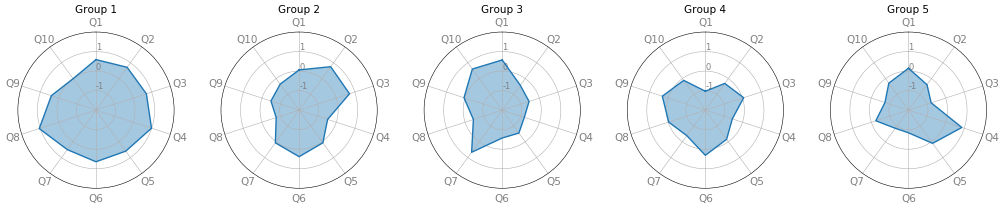

In [21]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(data_standardized.shape[1])]

for row in range(0, len(itemwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = itemwise_gmm[row]
    make_spider(items, values, row, ax, 'Group ' + str(row + 1), linestyle = 'solid')

Componentwise score in GMM

In [22]:
componentwise_gmm = list()

for i in range(1, num_components + 1):    
    componentwise_gmm.append(calc_mean_components_by_group(items_for_each_component, itemwise_gmm, i))

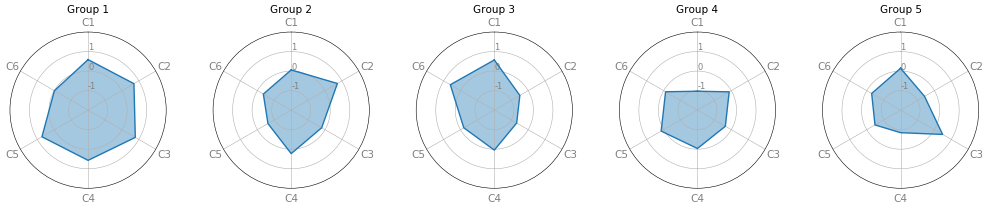

In [23]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_gmm[row].values()
    make_spider(components, values, row, ax, 'Group '+ str(row + 1), linestyle = 'solid')